In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize
import random
import cv2
import pandas as pd
import ot
import ot.plot
import time
import numpy.linalg as la
import networkx as nx
import math
#from pointcloud_utils import vox_to_pointcloud
#import pointcloud_utils
from sklearn import manifold as man
# NOTE: RBFInterpolator needs scipy>=1.7.0
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator

In [2]:
print(os.getcwd())

/home/plt9158@uta.edu/Desktop/dog-breeds/dog-breeds


In [3]:
# Reading and processing the images
# Initialize parameters
input_folder = "/home/plt9158@uta.edu/Desktop/dog-breeds/dog-breeds"
output_folder = "/home/plt9158@uta.edu/Desktop/dog-breeds/dog-breeds/processed_images"

In [4]:
print(os.listdir(input_folder))

['datapoint.ipynb', 'DogWassmapold.ipynb', 'husky', 'rottweiler', 'poodle', 'MDS & ISO map embeddings.ipynb', 'processed_images_tsne', 'beagle', 'DogWassmap.ipynb', 'processed_images', 'tSNE & LocallyLinearEmbedding & SpectralEmbedding.ipynb', 'bulldog', 'german-shepherd', '.ipynb_checkpoints', 'dalmatian', 'labrador-retriever']


In [5]:
# Function to convert color image to grayscale
def convert_to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Function to resize image
def resize_image(img, dim=(224, 224)):
    return cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

image_files = []
images_for_mds = []
images_labels = []

breed_folders = [f for f in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, f))]

# Loop through each breed input folder
for breed_folder in breed_folders:
    breed_path = os.path.join(input_folder, breed_folder)
    image_extensions = ['.jpg', '.png', '.jpeg']
    
    breed_image_files = [f for f in os.listdir(breed_path) if any(f.lower().endswith(ext) for ext in image_extensions)]
    
    for image_file in tqdm(breed_image_files):
        img_path = os.path.join(breed_path, image_file)
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Failed to load {img_path}")
            continue

        # Populate the image_files list with tuples
        image_files.append((breed_folder, image_file))
        
        # Convert to grayscale and resize
        gray_img = convert_to_grayscale(img)
        resized_gray_img = resize_image(gray_img)
        
        #print(resized_gray_img.shape)
        
        # Save the processed image
        breed_output_folder = os.path.join(output_folder, breed_folder)
        if not os.path.exists(breed_output_folder):
            os.makedirs(breed_output_folder)
        
        output_path = os.path.join(breed_output_folder, image_file)
        cv2.imwrite(output_path, resized_gray_img)
        
        # Preparing data for MDS on color images (resize color images)
        #color_resized_img = resize_image(img)
        images_for_mds.append(resized_gray_img.reshape(-1))
        images_labels.append(breed_folder)  # adding the breed label for each image
        

100%|███████████████████████████████████████████| 56/56 [00:00<00:00, 69.86it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 83/83 [00:01<00:00, 78.98it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 76/76 [00:01<00:00, 69.45it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 78.25it/s]


In [6]:
def vox_to_pointcloud(voxarray,grid,eps=0):
    # Convert a voxel representation ('voxarray') to a (weighted) point cloud representation
    # Assume that the input grid is in "ij meshgrid" format i.e. the grid has two layers, xx and yy, each size (nx)-by-(ny)
    # The voxel array will be unrolled via "column-major" order ("Fortran/Matlab" ordering)
    # Note that initially the number of voxels must equal the number of grid points - but
    # zero voxels will be removed from the representation (i.e. no points with weight zero allowed)
    # if the optional parameter eps is passed, voxels with value less or equal to eps will be dropped
    # The returned array consists of (x,y,w) tuples i.e. X = [x1,y1,w1;x2,y2,w2;...;xP,yP,wP] where P
    # is the number of nonzero points
    xx,yy = np.squeeze(np.split(grid,2))
    X = np.vstack((xx.ravel(),yy.ravel())).T
    nX  = X.shape[0] # Number of points = number of rows
    nvi = voxarray.shape[0] # Number of voxel rows
    nvj = voxarray.shape[1] # Number of voxel cols
    if nX != nvi*nvj: raise ValueError("Number of grid points must equal number of voxels!")
    print(X.shape)
    print(voxarray.T.shape)
    X = np.concatenate((X,voxarray.T.reshape(nvi*nvj,1)),axis=1)
    return X[X[:,2]>eps,:]


def pointcloud_to_vox(array,grid):
    # Converts a pointcloud representation to a voxel representation
    # Assumes that the grid is in "ij meshgrid" format i.e. grid has two layers, xx and yy; each are size (nx+1)-by-(ny+1)
    # The grid points are assumed to define the corners of the voxels, so the
    # voxel rep will be a single nx-by-ny array with entries equal to the average pointcloud weights
    # V_ij = \mean_k W_k if (x_k,y_k) is in voxel ij
    xx,yy = np.squeeze(np.split(grid,2))

    points = array[:,0:2]
    values = array[:,2]
#   interp = NearestNDInterpolator(points,values)
    interp = LinearNDInterpolator(points,values,fill_value=0.0)
    X = interp(xx,yy).T
    #interp = RBFInterpolator(points,values,smoothing=0,kernel='linear')
    #X = np.reshape(interp(np.vstack((xx.ravel(),yy.ravel())).T),(xx.shape[0],xx.shape[1]))
    return X

(12, 2)
(3, 4)


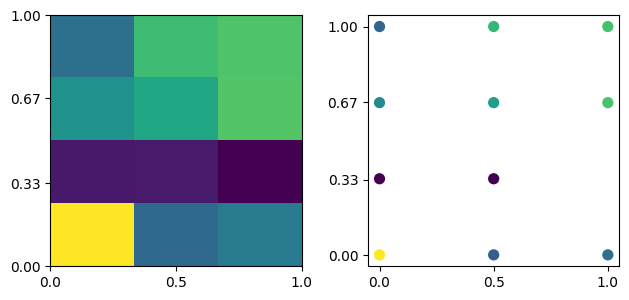

In [7]:
# Testing voxel-to-pointcloud conversion

# First, create voxel array
numx = 3
numy = 4

voxarray = np.random.rand(numy,numx)  # Note: number of rows = number of y points
# Set one of the elements to zero (to check zero weight handling)
voxarray[1,2] = 0

# Create a pointcloud grid for vox-to-PC conversion
nxg = numx
nyg = numy
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
# Convert voxel array to pointcloud
X = vox_to_pointcloud(voxarray,grid)
# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)

ax1.imshow(voxarray,origin='lower',extent=(0,1,0,1))
ax1.set_xticks(np.round(x,2))
ax1.set_yticks(np.round(y,2))
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)
ax2.set_xticks(np.round(x,2))
ax2.set_yticks(np.round(y,2))
fig1.tight_layout()

(0.0, 1.0)

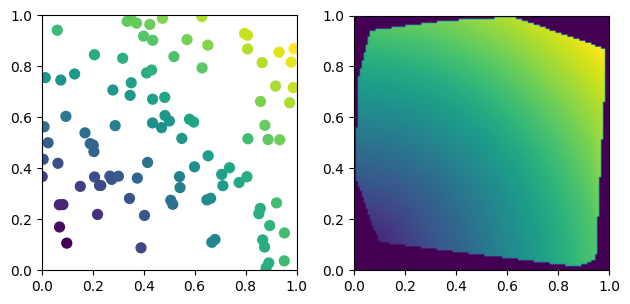

In [8]:
# Testing pointcloud-to-voxel conversion

# Generate a pointcloud by selecting random points
nPC = 100
points = np.random.rand(nPC,2)
values = np.hypot(points[:,0],points[:,1])
PCarray = np.hstack((points,values[:,np.newaxis]))
# Create a grid for pointcloud-to-voxel conversion
nxg = 129
nyg = 129
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
Y = pointcloud_to_vox(PCarray,grid)

fig2,(ax3,ax4) = plt.subplots(1,2)
fig2.tight_layout()
ax3.scatter(PCarray[:,0],PCarray[:,1],s=50,c=PCarray[:,2])
ax4.imshow(Y,origin='lower',extent=[0,1,0,1])
ax3.set_aspect(1)
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)

In [9]:
# Testing meshgrid, stack and split ops
nxg = 3
nyg = 4
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
xx2,yy2 = np.squeeze(np.split(grid,2))
#
display(xx)
display(yy)
display(grid)
display(xx2)
display(yy2)

array([[0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. ]])

array([[0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ]])

array([[[0.        , 0.        , 0.        , 0.        ],
        [0.5       , 0.5       , 0.5       , 0.5       ],
        [1.        , 1.        , 1.        , 1.        ]],

       [[0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ]]])

array([[0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. ]])

array([[0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ]])

In [10]:
# Testing meshgrid, stack and split ops
nxg = 3
nyg = 4
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
xx2,yy2 = np.squeeze(np.split(grid,2))
#
display(xx)
display(yy)
display(grid)
display(xx2)
display(yy2)

array([[0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. ]])

array([[0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ]])

array([[[0.        , 0.        , 0.        , 0.        ],
        [0.5       , 0.5       , 0.5       , 0.5       ],
        [1.        , 1.        , 1.        , 1.        ]],

       [[0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ]]])

array([[0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. ]])

array([[0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ]])

grid shape (2, 224, 224)
(50176, 2)
(224, 224)


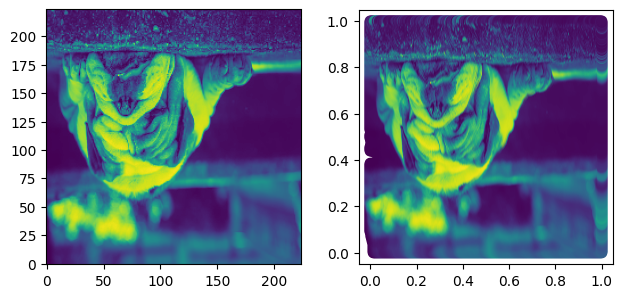

In [11]:
nxg = 224
nyg = 224
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
print("grid shape",grid.shape)
# Convert voxel array to pointcloud

def load_image_from_file(path):
    # Load the image
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (nxg, nyg))
    return image
    
path = "/home/plt9158@uta.edu/Desktop/dog-breeds/dog-breeds/bulldog/bulldog10.jpg"
voxarray = load_image_from_file(path)
X = vox_to_pointcloud(voxarray, grid)


# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)
fig1.tight_layout()
ax1.imshow(voxarray,origin='lower')
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)
#print(X.shape)
#print(X)

In [12]:
x = np.linspace(0,1,voxarray.shape[1])
y = np.linspace(0,1,voxarray.shape[0])
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
print("grid shape",grid.shape)

grid shape (2, 224, 224)


grid shape (2, 224, 224)
(50176, 2)
(224, 224)


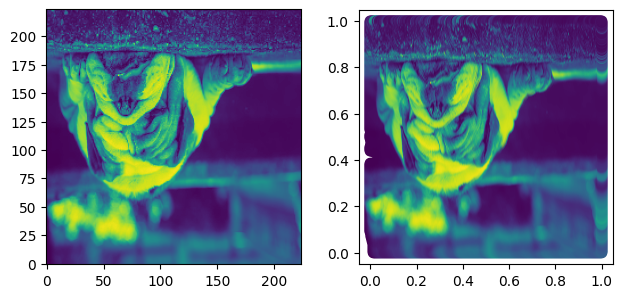

In [13]:
x = np.linspace(0,1,voxarray.shape[1])
y = np.linspace(0,1,voxarray.shape[0])
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
print("grid shape",grid.shape)
# Convert voxel array to pointcloud

def load_image_from_file(path):
    # Load the image
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image at path {path} could not be loaded. Check if the path is correct and points to an image file.")
    image = cv2.resize(image,(224,224))
    return image
    
path = "/home/plt9158@uta.edu/Desktop/dog-breeds/dog-breeds/bulldog/bulldog10.jpg"
voxarray = load_image_from_file(path)
X = vox_to_pointcloud(voxarray, grid)


# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)
fig1.tight_layout()
ax1.imshow(voxarray,origin='lower')
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)
#print(X.shape)
#print(X)

In [15]:
def prepare_grid(nxg=224, nyg=224):
    x = np.linspace(0, 1, nxg)
    y = np.linspace(0, 1, nyg)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    grid = np.stack((xx, yy))
    return grid

dataset_path = "/home/plt9158@uta.edu/Desktop/dog-breeds/dog-breeds"
breeds = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
image_paths = []
image_labels = []  


images_per_breed = 10 # Number of images to process per breed
random.seed(42)  # For reproducible random selection

for breed in breeds:
    breed_path = os.path.join(dataset_path, breed)
    breed_images = [os.path.join(breed_path, img) for img in os.listdir(breed_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Randomly select a subset of images from the current breed
    if len(breed_images) > images_per_breed:
        selected_images = random.sample(breed_images, images_per_breed)
    else:
        selected_images = breed_images  # Use all images if less than the target number per breed
    
    image_paths.extend(selected_images)
    image_labels.extend([breed] * len(selected_images))  # Extend the labels list by repeating the breed name

point_clouds = []
for path in image_paths:
    voxarray = load_image_from_file(path)
    grid = prepare_grid()
    point_cloud = vox_to_pointcloud(voxarray, grid)
    point_clouds.append(point_cloud)

(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)

In [16]:
test_image_path = image_paths[0]
voxarray = load_image_from_file(test_image_path)
grid = prepare_grid(nxg=224,nyg=224)

point_cloud = vox_to_pointcloud(voxarray, grid)
print("suceess")

(50176, 2)
(224, 224)
suceess


In [17]:
def generate_rectangle(side0, side1, initial_point=[0,0], samples=100):
    # Generates a rectangle in point cloud format
    x = np.linspace(initial_point[0], initial_point[0]+side0, num=samples)
    y = np.linspace(initial_point[1], initial_point[1]+side1, num=samples)
    return np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

def in_triangle(endpoint1,endpoint2,endpoint3,point):
    # Indicator function of a triangle
    # Returns 1 (True) if point is in the triangle, zero (False) else
    c1 = (endpoint2[0]-endpoint1[0])*(point[1]-endpoint1[1]) - (endpoint2[1]-endpoint1[1])*(point[0]-endpoint1[0])
    c2 = (endpoint3[0]-endpoint2[0])*(point[1]-endpoint2[1]) - (endpoint3[1]-endpoint2[1])*(point[0]-endpoint2[0])
    c3 = (endpoint1[0]-endpoint3[0])*(point[1]-endpoint3[1]) - (endpoint1[1]-endpoint3[1])*(point[0]-endpoint3[0])

    if (c1<0 and c2<0 and c3<0) or (c1>0 and c2>0 and c3>0):
        return True
    else:
        return False

def generate_triangle(endpoint1, endpoint2, endpoint3, samples=100):
    # Generates a triangle in point cloud format
    x = np.linspace(min(endpoint1[0],endpoint2[0],endpoint3[0]), max(endpoint1[0],endpoint2[0],endpoint3[0]), num=samples)
    y = np.linspace(min(endpoint1[1],endpoint2[1],endpoint3[1]), max(endpoint1[1],endpoint2[1],endpoint3[1]), num=samples)
    xy_0 = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    xy = []
    for point in xy_0:
        if in_triangle(endpoint1,endpoint2,endpoint3,point):
            xy.append(point)
    return np.array(xy)

def in_circle(center, radius, point):
    if (point[1]-center[1])**2+(point[0]-center[0])**2<=radius**2:
        return True
    else:
        return False

def generate_circle(center, radius, samples=100):
    x = np.linspace(center[0]-radius, center[0]+radius, num=samples)
    y = np.linspace(center[1]-radius, center[1]+radius, num=samples)
    xy_0 = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    xy = []
    for point in xy_0:
        if in_circle(center,radius,point):
            xy.append(point)
    return np.array(xy)

def generate_ellipse(center, axis_x, axis_y,samples = 100):
    circle = generate_circle([0,0],1,samples)
    ellipse = dilation(circle,[axis_x, axis_y])
    ellipse = translation(ellipse,center)
    return np.array(ellipse)

In [18]:
def uniform_Wass_squared(U, V,Itermax=100000):
    # Assumes that U and V are pointclouds i.e. U = [x1,y1,w1;...;xp,yp,wp] etc
    Upts = np.ascontiguousarray(U[:,0:2])
    Vpts = np.ascontiguousarray(V[:,0:2])
    Uwts = np.ascontiguousarray(U[:,2])
    Vwts = np.ascontiguousarray(V[:,2])
    Uwts = Uwts/np.sum(Uwts)
    Vwts = Vwts/np.sum(Vwts)
    M = ot.dist(Upts, Vpts)  # Compute euclidean distance on the pointcloud points
    W = ot.emd2(Uwts,Vwts, M,numItermax=Itermax)
    return W

def Wasserstein_Matrix(image_list,squared=True):
    """
    The function compute the (squared if squared=True) Wasserstein Distance Matrix between N images
    image_list: python list of pointcloud representations
    """
    N = len(image_list) #number of images
    distance = np.zeros((N,N)) #initialize the distance matrix

    #cost = ot.dist(supp, supp) #should be a MXM array
    for i in range(N):
        for j in range(i+1,N):
            if squared==True:
                distance[i,j] = uniform_Wass_squared(image_list[i], image_list[j])
            else:
                distance[i,j] = uniform_Wass_squared(image_list[i], image_list[j])**.5
    distance += distance.T
    return distance

def Euclidean_Matrix(image_tensor,squared=True):
    """
    The function compute the (squared if squared=True) Euclidean Distance Matrix between N 2D images
    image_tensor: Should be a Mx2xN array, where M is the number of pixels.
    """
    N = image_tensor.shape[-1] #number of rows
    distance = np.zeros((N,N)) #initialize the distance matrix
    for i in range(N):
        for j in range(i+1,N):
            if squared==True:
                distance[i,j] = la.norm(image_tensor[:,:,i]-image_tensor[:,:,j])**2
            else:
                distance[i,j] = la.norm(image_tensor[:,:,i]-image_tensor[:,:,j])
    distance += distance.T
    return distance

def Geodesic_Matrix(image_tensor,eps,squared=True):
    """
    Computes the Geodesic distance matrix for a set of N images
    image_tensor is Mx2xN
    """
    Euc_distance = Euclidean_Matrix(image_tensor,squared=False)
    Adj_matrix = np.copy(Euc_distance)
    Adj_matrix[Adj_matrix<eps] = 0
    Euc_distance[Euc_distance<eps] = np.Inf
    G = nx.from_numpy_array(Adj_matrix)
    geo_matrix = shortest_path(Euc_distance, directed=False, return_predecessors=False)
    if(squared==True):
        geo_matrix = np.square(geo_matrix)
    return geo_matrix,G

def MDS(distance_matrix, num_components=2, squared=False):
    """
    Computes non-metric (classical) Multidimensional Scaling (MDS)
    Input should be an NxN distance matrix
    The Boolean squared indicates if the distance matrix passed to the function has already
    been squared entrywise (True) or not (False)
    """
    N = distance_matrix.shape[0]
    H = np.eye(N)-1/N*np.ones((N,N))
    if squared==False:
        B = -.5*H@(distance_matrix**2)@H
    else:
        B = -.5*H@distance_matrix@H
    U,S,VT = la.svd(B)
    embedding = U[:,:num_components]@np.diag(S[:num_components]**.5)
    return embedding

In [19]:
def rotation(object, radian_degree):
    A = [[math.cos(radian_degree), -math.sin(radian_degree)],[math.sin(radian_degree), math.cos(radian_degree)]]
    image = []
    for index,point in enumerate(object):
        image.append(np.matmul(A,point))
    return np.array(image)
def translation(object, translate_direction):
    object_array = np.array(object)
    direction_array = np.array(translate_direction)
    image = [x + direction_array for x in object_array]
    return np.array(image)

def dilation(object, parameter):
    A = [[parameter[0], 0],[0, parameter[1]]]
    image = []
    for index,point in enumerate(object):
        image.append(np.matmul(A,point))
    return np.array(image)

# def diffeo(object, diff_fun):
#     object_array = np.array(object)
#     image = [diff_fun(x) for x in object_array]
#     return np.array(image)

def diffeo(object, a,b):
    object_array = np.array(object)
    image = np.array([1/(a*b*np.exp(a*object_array[:,0])*np.exp(b*object_array[:,1]))*np.exp(a*object_array[:,0]), 1/(a*b*np.exp(a*object_array[:,0])*np.exp(b*object_array[:,1]))*np.exp(b*object_array[:,1])]).T
#    image = np.array([np.exp(a*object_array[:,0]), np.reciprocal((1+b*object_array[:,1])**2)]).T
    print(image.shape)
    return np.array(image)

/tmp/ipykernel_197928/913623156.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  translates[i,0] = xx[i]
/tmp/ipykernel_197928/913623156.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  translates[i,1] = yy[i]


(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)

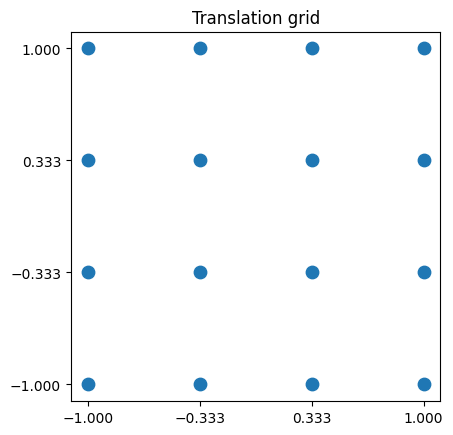

In [20]:
##Circle translate test 1:OVERLAPPING IMAGES::Image generation and setup
# NOTE: In this test, the translation grid is such that the resulting synthetic
# images will overlap.  Thus, Isomap is at least well-defined (i.e. there are meaningful geodesics)

# Generate circle
num_samplepoints = 32
circ = generate_circle([0,0],1,samples=num_samplepoints)

# Generate translation set
num_translates = 4
num_samp = num_translates**2
x = np.linspace(-1,1,num=num_translates)
y = np.linspace(-1,1,num=num_translates)
xx,yy = np.meshgrid(x,y) #num_translates x num_translates matrices; each xx,yy entry is a translation vector
xx = np.reshape(xx,(num_translates**2,1))
yy = np.reshape(yy,(num_translates**2,1))
translates = np.zeros((num_translates**2,2))
for i in range(len(xx)):
    translates[i,0] = xx[i]
    translates[i,1] = yy[i]

# Plot the translation set
fig1,ax1 = plt.subplots()
ax1.scatter(translates[:,0],translates[:,1],s=80)
ax1.set_aspect('equal')
ax1.set_title('Translation grid')
ax1.set_xticks(x)
ax1.set_yticks(y)

#plt.savefig('/content/drive/My Drive/Colab Notebooks/figures/trans1_paramset.pdf',bbox_inches='tight')

trans_images = []
for path in image_paths:
    voxarray = load_image_from_file(path)
    grid = prepare_grid()
    point_cloud = vox_to_pointcloud(voxarray, grid)
    trans_images.append(point_cloud)

In [23]:
import cupy as cp

In [27]:
def cupy_uniform_wass_squared_sinkhorn(U, V, p=2, reg=1):
    Upts = cp.ascontiguousarray(U[:,0:2])
    Vpts = cp.ascontiguousarray(V[:,0:2])
    Uwts = cp.ascontiguousarray(U[:,2])
    Vwts = cp.ascontiguousarray(V[:,2])
    Uwts /= cp.sum(Uwts)
    Vwts /= cp.sum(Vwts)
    M = cp.power(cp.linalg.norm(Upts[:, None] - Vpts, axis=-1), p)  # Compute euclidean distance on the pointcloud points
    W = ot.sinkhorn2(Uwts, Vwts, M, reg)
    return W
 
def cupy_wass_matrix(image_list, squared=True, p=2.0, geodesic=False, eps=0, plot=False, returngraph=False, geomethod='eps', k=3, wassmethod='emd2', sinkhornreg=1):
    N = len(image_list)
    wass_dist = cp.zeros((N, N))
    for i in range(N):
        for j in range(i+1, N):
            if wassmethod == 'emd2':
                if squared:
                    wass_dist[i, j] = uniform_wass_squared(image_list[i], image_list[j], p=p)
                else:
                    wass_dist[i, j] = uniform_wass_squared(image_list[i], image_list[j], p=p)**(1.0/p)
            elif wassmethod == 'sinkhorn':
                if squared:
                    wass_dist[i, j] = cupy_uniform_wass_squared_sinkhorn(image_list[i], image_list[j], p=p, reg=sinkhornreg)
                else:
                    wass_dist[i, j] = cupy_uniform_wass_squared_sinkhorn(image_list[i], image_list[j], p=p, reg=sinkhornreg)**(1.0/p)
 
    wass_dist += wass_dist.T
    return cp.asnumpy(wass_dist)

In [54]:
nxg = 128
nyg = 128
x = np.linspace(0, 1, nxg)
y = np.linspace(0, 1, nyg)
xx, yy = np.meshgrid(x, y, indexing='ij')
grid = np.stack((xx,yy), axis=-1)

In [79]:
zeros_pointcloud = []
for point_cloud in point_clouds:
    filter = point_cloud[point_cloud[:,2]>-1]
    zeros_pointcloud.append(filter)

In [82]:
# Check the shape of each point cloud
shapes = [pc.shape for pc in zeros_pointcloud if isinstance(pc, np.ndarray)]
print(set(shapes))  # This will show you the unique shapes of the arrays

{(50117, 3), (50163, 3), (50174, 3), (50156, 3), (50158, 3), (50085, 3), (50173, 3), (49997, 3), (50162, 3), (50065, 3), (50142, 3), (50175, 3), (50155, 3), (50144, 3), (49915, 3), (50157, 3), (50124, 3), (50005, 3), (49776, 3), (50170, 3), (50150, 3), (50176, 3)}


In [83]:
# Convert each point cloud to a CuPy array and store in a new list
cupy_zeros_pointcloud = [cp.asarray(pc) for pc in zeros_pointcloud if isinstance(pc, np.ndarray)]

In [88]:
# Sample indices from the list of CuPy arrays
random_zeros = np.random.choice(len(cupy_zeros_pointcloud), size=10, replace=False)

# Select the point clouds corresponding to the sampled indices
selected_point_clouds = [cupy_zeros_pointcloud[i] for i in random_zeros]

# Compute the Wasserstein distance matrix using the selected point clouds
tic = time.perf_counter()
Wass_distance = cupy_wass_matrix(selected_point_clouds, squared=True, wassmethod='sinkhorn')
toc = time.perf_counter() - tic
print(toc)

OutOfMemoryError: Out of memory allocating 40,072,560,640 bytes (allocated so far: 101,328,384 bytes).

In [89]:
# Use a smaller subset of point clouds for testing
smaller_subset = cupy_zeros_pointcloud[:10]  # adjust the number to fit your memory capacity
random_zeros = np.random.choice(len(smaller_subset), size=min(10, len(smaller_subset)), replace=False)
selected_point_clouds = [smaller_subset[i] for i in random_zeros]

In [90]:
# Compute the Wasserstein distance matrix using the selected point clouds
tic = time.perf_counter()
Wass_distance = cupy_wass_matrix(selected_point_clouds, squared=True, wassmethod='sinkhorn')
toc = time.perf_counter() - tic
print(toc)

OutOfMemoryError: Out of memory allocating 40,266,039,296 bytes (allocated so far: 101,328,384 bytes).

In [91]:
# Compute Wasserstein square distance matrix
random_zeros = np.random.choice(range(len(cupy_zeros_pointcloud)),size=80,replace=False)
#selected_labels = target_labels[random_zeros]
tic = time.perf_counter()
# Note the index trick for constructing the list of randomized zeros
Wass_distance = cupy_wass_matrix([cupy_zeros_pointcloud[i] for i in random_zeros], squared=True, wassmethod='sinkhorn')
toc = time.perf_counter() - tic
print(toc)

OutOfMemoryError: Out of memory allocating 40,278,884,864 bytes (allocated so far: 101,334,528 bytes).

In [48]:
print(point_clouds)

[array([[0.00000000e+00, 0.00000000e+00, 1.40000000e+02],
       [0.00000000e+00, 4.48430493e-03, 1.40000000e+02],
       [0.00000000e+00, 8.96860987e-03, 1.40000000e+02],
       ...,
       [1.00000000e+00, 9.91031390e-01, 1.03000000e+02],
       [1.00000000e+00, 9.95515695e-01, 1.01000000e+02],
       [1.00000000e+00, 1.00000000e+00, 9.90000000e+01]]), array([[0.00000000e+00, 0.00000000e+00, 2.21000000e+02],
       [0.00000000e+00, 4.48430493e-03, 2.20000000e+02],
       [0.00000000e+00, 8.96860987e-03, 2.19000000e+02],
       ...,
       [1.00000000e+00, 9.91031390e-01, 1.67000000e+02],
       [1.00000000e+00, 9.95515695e-01, 1.72000000e+02],
       [1.00000000e+00, 1.00000000e+00, 1.70000000e+02]]), array([[0.00000000e+00, 0.00000000e+00, 1.91000000e+02],
       [0.00000000e+00, 4.48430493e-03, 1.94000000e+02],
       [0.00000000e+00, 8.96860987e-03, 1.94000000e+02],
       ...,
       [1.00000000e+00, 9.91031390e-01, 1.43000000e+02],
       [1.00000000e+00, 9.95515695e-01, 1.73000

/home/plt9158@uta.edu/.local/lib/python3.10/site-packages/ot/lp/__init__.py:571: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


Computed Wasserstein distance matrix (N = 16) in 422161.8719 seconds


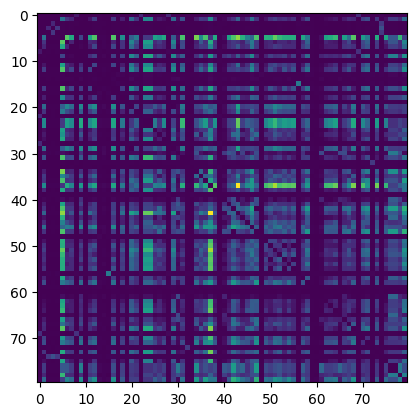

In [21]:
 ## Circle translation test :: Compute Wasserstein square distance matrix usinng this
tic = time.perf_counter()
Wass_distance_trans = Wasserstein_Matrix(trans_images,squared=True)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))

In [22]:
label_to_color = {
    'rottweiler': 'r',
    'dalmatian': 'g',
    'german-shepherd': 'b',
    'beagle': 'c',
    'husky': 'm',
    'poodle': 'y',
    'bulldog': 'k',
    'labrador-retriever': 'orange',
}

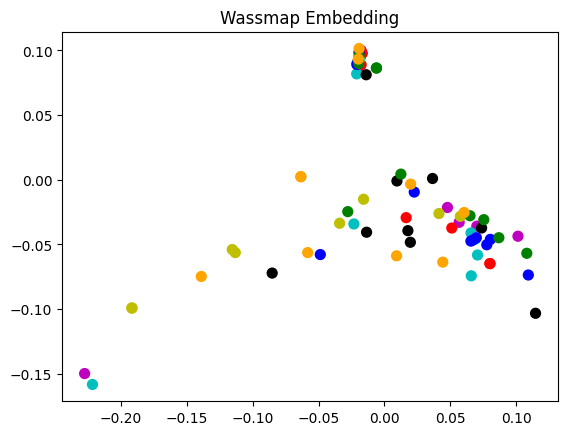

In [23]:
WassEmbedding_trans = MDS(Wass_distance_trans, squared=True)
fig, ax1 = plt.subplots()
scatter_x = WassEmbedding_trans[:, 0]
scatter_y = WassEmbedding_trans[:, 1]
colors = [label_to_color.get(label, 'gray') for label in image_labels]
sc = ax1.scatter(scatter_x, scatter_y, c=colors, s=50)
ax1.set_title('Wassmap Embedding')
#plt.colorbar(sc, ax=ax1, orientation='vertical', pad=0.02)
plt.show()

In [31]:
isomap = Isomap(n_components=10, metric='precomputed')
WassEmbedding_isomap = isomap.fit_transform(Wass_distance_trans)

In [25]:
from sklearn.manifold import MDS, Isomap, TSNE, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph

In [26]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
WassEmbedding_mds = mds.fit_transform(Wass_distance_trans)

In [27]:
tsne = TSNE(n_components=2, metric ='precomputed',init = 'random',random_state=42, perplexity=5)
WassEmbedding_tsne = tsne.fit_transform(Wass_distance_trans)

In [28]:
lle = LocallyLinearEmbedding(n_components=2, random_state=42) # n_neighbors=10)
WassEmbedding_lle = lle.fit_transform(Wass_distance_trans)

In [29]:
similarity_matrix = np.exp(-Wass_distance_trans ** 2 / (4. * np.std(Wass_distance_trans) ** 2))
spectral = SpectralEmbedding(n_components=2, affinity='precomputed', random_state=42)
WassEmbedding_spectral = spectral.fit_transform(similarity_matrix)

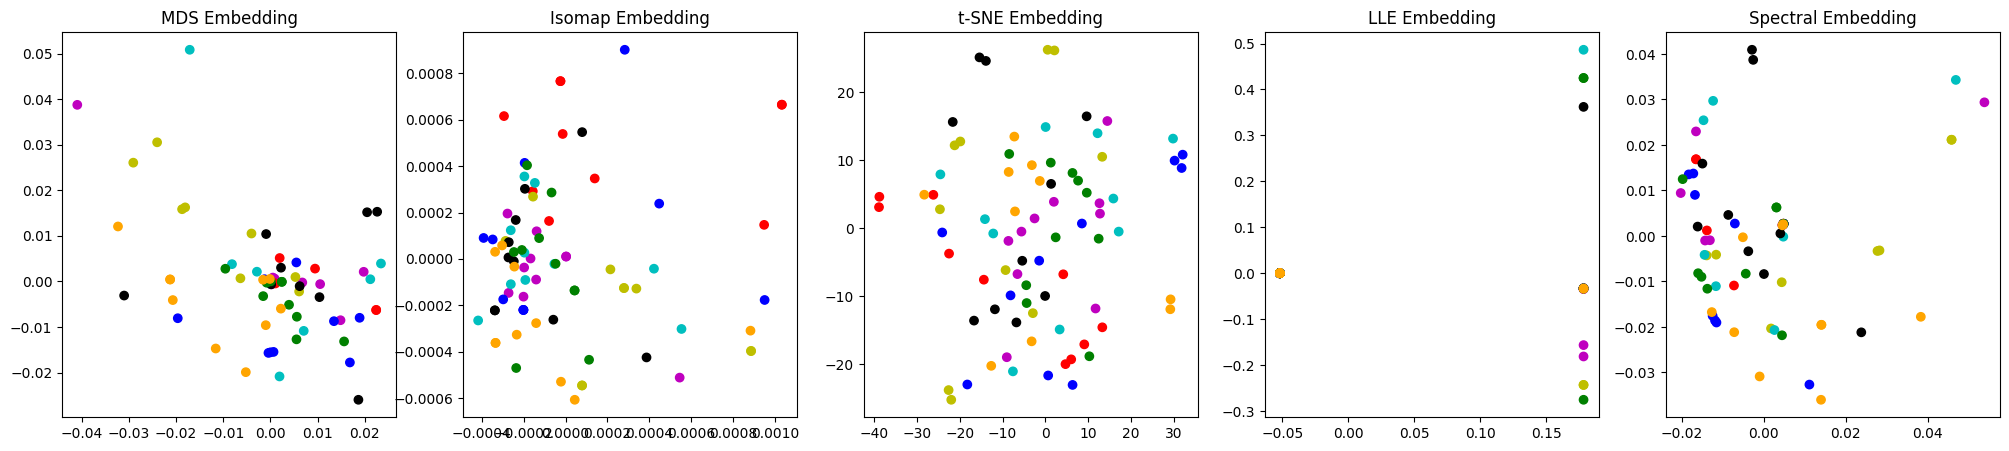

In [32]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

# MDS
axs[0].scatter(WassEmbedding_mds[:, 0], WassEmbedding_mds[:, 1], c=colors)
axs[0].set_title('MDS Embedding')

# Isomap
axs[1].scatter(WassEmbedding_isomap[:, 0], WassEmbedding_isomap[:, 1],c=colors)
axs[1].set_title('Isomap Embedding')

# t-SNE
axs[2].scatter(WassEmbedding_tsne[:, 0], WassEmbedding_tsne[:, 1], c=colors)
axs[2].set_title('t-SNE Embedding')

# LLE
axs[3].scatter(WassEmbedding_lle[:, 0], WassEmbedding_lle[:, 1], c=colors)
axs[3].set_title('LLE Embedding')

# Spectral
axs[4].scatter(WassEmbedding_spectral[:, 0], WassEmbedding_spectral[:, 1], c=colors)
axs[4].set_title('Spectral Embedding')

#plt.colorbar(axs[0].scatter(WassEmbedding_mds[:, 0], WassEmbedding_mds[:, 1],c=colors), ax=axs, orientation='horizontal', pad=0.1)
plt.show()


In [33]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import SpectralEmbedding

In [34]:
classifiers = {
    'LDA': LinearDiscriminantAnalysis(),
    'KNN (K=1)': KNeighborsClassifier(n_neighbors=1),
    'KNN (K=3)': KNeighborsClassifier(n_neighbors=3),
    'KNN (K=5)': KNeighborsClassifier(n_neighbors=5),
    'SVM Linear': SVC(kernel='linear'),
    'SVM RBF': SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(),
    'Multinomial Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000) 
}

In [35]:
X=np.array(images_for_mds)
y=np.array(images_labels)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [37]:
print(X_train.shape)
print(X_test.shape)

(378, 50176)
(163, 50176)


In [38]:
no_embedding_accuracies = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    no_embedding_accuracies[name] = accuracy
    #print(f"{name} - No Embedding: Accuracy = {accuracy:.2f}")

In [39]:
no_embedding_mean_std = {
    name: f"{np.mean(accs):.2f} ± {np.std(accs):.2f}"
    for name, accs in no_embedding_accuracies.items()}

no_embedding_df = pd.DataFrame([no_embedding_mean_std], index=['No Embedding'])
no_embedding_df

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
No Embedding,0.58 ± 0.00,0.74 ± 0.00,0.49 ± 0.00,0.33 ± 0.00,0.70 ± 0.00,0.61 ± 0.00,0.71 ± 0.00,0.70 ± 0.00


In [62]:
metrics = [True]
eps_values = [0.001, 0.01, 0.1]
embeddings = {}
for metric_value in metrics:
    for eps in eps_values:
        embedding = MDS(n_components=10, metric=metric_value, eps=eps)
        train_transformed = embedding.fit_transform(Wass_distance_trans)
        embeddings[(metric_value, eps)] = train_transformed

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


In [63]:
mds_accuracy_results = {name: [] for name in classifiers.keys()}

for (metric_value, eps), train_transformed in embeddings.items():
    X_train, X_test, y_train, y_test = train_test_split(train_transformed, image_labels, test_size=0.3, random_state=42)
    
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        mds_accuracy_results[name].append(accuracy)

In [64]:
mds_mean_std_accuracy_results = {}
for name, acc_list in mds_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    mds_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

mds_df = pd.DataFrame([mds_mean_std_accuracy_results], index=['MDS'])
mds_df

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
MDS,0.14 ± 0.05,0.25 ± 0.07,0.08 ± 0.03,0.12 ± 0.03,0.04 ± 0.00,0.08 ± 0.00,0.17 ± 0.07,0.04 ± 0.00


In [44]:
n_neighbors_values = [20, 30, 40, 50]
n_components_values = [10]

transformed_isomap_data_list = []
for n_neighbors_val in n_neighbors_values:
    for i, n_components_val in enumerate(n_components_values):
        isomap = Isomap(n_neighbors=n_neighbors_val, n_components=n_components_val, metric = 'precomputed')
        transformed_isomap_data = isomap.fit_transform(Wass_distance_trans)
        transformed_isomap_data_list.append((n_neighbors_val, n_components_val, transformed_isomap_data))

isomap_accuracy_results = {name: [] for name in classifiers.keys()}
for n_neighbors_val, n_components_val, transformed_data in transformed_isomap_data_list:
    X_train, X_test, y_train, y_test = train_test_split(train_transformed, image_labels, test_size=0.3, random_state=42)
    current_accuracies = {}
    
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        current_accuracies[name] = accuracy
        #print(f"{name} with Isomap (n_neighbors={n_neighbors_val}, n_components={n_components_val}) - Accuracy: {accuracy:.2f}")

   
    for name in isomap_accuracy_results:
        isomap_accuracy_results[name].append(current_accuracies[name])

isomap_mean_std_accuracy_results = {}
for name, acc_list in isomap_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    isomap_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

isomap_df = pd.DataFrame([isomap_mean_std_accuracy_results], index=['Isomap'])
isomap_df

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
Isomap,0.25 ± 0.00,0.21 ± 0.00,0.08 ± 0.00,0.08 ± 0.00,0.04 ± 0.00,0.08 ± 0.00,0.10 ± 0.05,0.04 ± 0.00


In [49]:
n_perplexity_values = [ 3, 5, 7]
n_components_values = [2, 3]

transformed_tsne_data_list = []
for perplexity_val in n_perplexity_values:
    for i, n_components_val in enumerate(n_components_values):
        tsne = TSNE(n_components=n_components_val, perplexity=perplexity_val, random_state=42)
        transformed_tsne_data = tsne.fit_transform(Wass_distance_trans)
        transformed_tsne_data_list.append((perplexity_val, n_components_val, transformed_tsne_data))

tsne_accuracy_results = {name: [] for name in classifiers.keys()}

for perplexity_val, n_components_val, transformed_data in transformed_tsne_data_list:
    X_train, X_test, y_train, y_test = train_test_split(train_transformed, image_labels, test_size=0.3, random_state=42)
    current_accuracies = {}
    
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        current_accuracies[name] = accuracy

        #print(f"{name} with t-SNE (perplexity={perplexity_val}, n_components={n_components_val}) - Accuracy: {accuracy:.2f}")

    for name in tsne_accuracy_results:
        tsne_accuracy_results[name].append(current_accuracies[name])

tsne_mean_std_accuracy_results = {}
for name, acc_list in tsne_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    tsne_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

tsne_df = pd.DataFrame([tsne_mean_std_accuracy_results], index=['t-SNE'])
tsne_df

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
t-SNE,0.25 ± 0.00,0.21 ± 0.00,0.08 ± 0.00,0.08 ± 0.00,0.04 ± 0.00,0.08 ± 0.00,0.08 ± 0.04,0.04 ± 0.00


In [47]:
n_neighbors_values = [ 2, 3, 5, 7]
n_components_values = [10]

transformed_lle_data_list = []
for n_neighbors_val in n_neighbors_values:
    for i, n_components_val in enumerate(n_components_values):
        lle = LocallyLinearEmbedding(n_neighbors=n_neighbors_val, n_components=n_components_val)
        transformed_lle_data = lle.fit_transform(Wass_distance_trans)
        transformed_lle_data_list.append((n_neighbors_val, n_components_val, transformed_lle_data))     

lle_accuracy_results = {name: [] for name in classifiers.keys()}

for n_neighbors_val, n_components_val, transformed_data in transformed_lle_data_list:
    X_train, X_test, y_train, y_test = train_test_split(train_transformed, image_labels, test_size=0.3, random_state=42)
    current_accuracies = {}

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        current_accuracies[name] = accuracy
        #print(f"{name} with LLE (n_neighbors={n_neighbors_val}, n_components={n_components_val}) - Accuracy: {accuracy:.2f}")

    for name in lle_accuracy_results:
        lle_accuracy_results[name].append(current_accuracies[name])

lle_mean_std_accuracy_results = {}
for name, acc_list in lle_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    lle_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

lle_df_10 = pd.DataFrame([lle_mean_std_accuracy_results], index=['LLE'])
lle_df_10

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
LLE,0.25 ± 0.00,0.21 ± 0.00,0.08 ± 0.00,0.08 ± 0.00,0.04 ± 0.00,0.08 ± 0.00,0.08 ± 0.03,0.04 ± 0.00


In [48]:
n_neighbors_values = [ 3, 5, 7,10]
n_components_values = [10]

transformed_spectral_data_list = []
for n_neighbors_val in n_neighbors_values:
    for i, n_components_val in enumerate(n_components_values):
        spectral = SpectralEmbedding(n_neighbors=n_neighbors_val, n_components=n_components_val)
        transformed_spectral_data = spectral.fit_transform(Wass_distance_trans)
        transformed_spectral_data_list.append((n_neighbors_val, n_components_val, transformed_spectral_data))

spectral_accuracy_results = {name: [] for name in classifiers.keys()}

for n_neighbors_val, n_components_val, transformed_data in transformed_spectral_data_list:
    X_train, X_test, y_train, y_test = train_test_split(train_transformed, image_labels, test_size=0.3, random_state=42)
    current_accuracies = {}

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        current_accuracies[name] = accuracy
        #print(f"{name} with Spectral Embedding (n_neighbors={n_neighbors_val}, n_components={n_components_val}) - Accuracy: {accuracy:.2f}")

    for name in spectral_accuracy_results:
        spectral_accuracy_results[name].append(current_accuracies[name])

spectral_mean_std_accuracy_results = {}
for name, acc_list in spectral_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    spectral_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

spectral_df_10 = pd.DataFrame([spectral_mean_std_accuracy_results], index=['Spectral Embedding'])
spectral_df_10

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
Spectral Embedding,0.25 ± 0.00,0.21 ± 0.00,0.08 ± 0.00,0.08 ± 0.00,0.04 ± 0.00,0.08 ± 0.00,0.07 ± 0.03,0.04 ± 0.00


In [65]:
combined_df = pd.concat([no_embedding_df, mds_df, isomap_df, tsne_df, lle_df_10, spectral_df_10])
combined_df

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
No Embedding,0.58 ± 0.00,0.74 ± 0.00,0.49 ± 0.00,0.33 ± 0.00,0.70 ± 0.00,0.61 ± 0.00,0.71 ± 0.00,0.70 ± 0.00
MDS,0.14 ± 0.05,0.25 ± 0.07,0.08 ± 0.03,0.12 ± 0.03,0.04 ± 0.00,0.08 ± 0.00,0.17 ± 0.07,0.04 ± 0.00
Isomap,0.25 ± 0.00,0.21 ± 0.00,0.08 ± 0.00,0.08 ± 0.00,0.04 ± 0.00,0.08 ± 0.00,0.10 ± 0.05,0.04 ± 0.00
t-SNE,0.25 ± 0.00,0.21 ± 0.00,0.08 ± 0.00,0.08 ± 0.00,0.04 ± 0.00,0.08 ± 0.00,0.08 ± 0.04,0.04 ± 0.00
LLE,0.25 ± 0.00,0.21 ± 0.00,0.08 ± 0.00,0.08 ± 0.00,0.04 ± 0.00,0.08 ± 0.00,0.08 ± 0.03,0.04 ± 0.00
Spectral Embedding,0.25 ± 0.00,0.21 ± 0.00,0.08 ± 0.00,0.08 ± 0.00,0.04 ± 0.00,0.08 ± 0.00,0.07 ± 0.03,0.04 ± 0.00


In [54]:
from scipy.stats import ttest_ind
techniques_10 = combined_df.index.tolist()

In [55]:
def perform_one_sided_ttest(no_embedding_means, technique_means):
    t_stat, p_value = ttest_ind( technique_means,no_embedding_means, equal_var=False, alternative = 'less')
    #if t_stat > 0:
        #p_value /= 2
    #else:
        #p_value = 1 - (p_value / 2)
    return p_value

ttest_results_10 = {}
for technique in techniques_10:
    if technique == 'No Embedding':
        continue
    
    # Extract the mean accuracies as floats
    no_embedding_means = combined_df.loc['No Embedding'].str.split(' ± ').str[0].astype(float)
    technique_means = combined_df.loc[technique].str.split(' ± ').str[0].astype(float)
    
    # Perform the one-sided t-test
    p_value = perform_one_sided_ttest(no_embedding_means, technique_means)
    ttest_results_10[technique] = p_value

In [56]:
print("One-Sided T-Test Results for 10 Components:")
for technique, p_value in ttest_results_10.items():
    print(f"{technique}: p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("  Significant difference at p < 0.05, reject H0")
    else:
        print("  No significant difference, fail to reject H0")

One-Sided T-Test Results for 10 Components:
MDS: p-value = 0.0000
  Significant difference at p < 0.05, reject H0
Isomap: p-value = 0.0000
  Significant difference at p < 0.05, reject H0
t-SNE: p-value = 0.0000
  Significant difference at p < 0.05, reject H0
LLE: p-value = 0.0000
  Significant difference at p < 0.05, reject H0
Spectral Embedding: p-value = 0.0000
  Significant difference at p < 0.05, reject H0


In [95]:
metrics = [True]
eps_values = [0.001, 0.01, 0.1]
embeddings = {}
for metric_value in metrics:
    for eps in eps_values:
        embedding = MDS(n_components=60, metric=metric_value, eps=eps)
        train_transformed = embedding.fit_transform(Wass_distance_trans)
        embeddings[(metric_value, eps)] = train_transformed

mds_accuracy_results = {name: [] for name in classifiers.keys()}

for (metric_value, eps), train_transformed in embeddings.items():
    X_train, X_test, y_train, y_test = train_test_split(train_transformed, image_labels, test_size=0.3, random_state=42)
    
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        mds_accuracy_results[name].append(accuracy)

mds_mean_std_accuracy_results = {}
for name, acc_list in mds_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    mds_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

mds_df_100 = pd.DataFrame([mds_mean_std_accuracy_results], index=['MDS'])
mds_df_100

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
MDS,0.22 ± 0.05,0.19 ± 0.09,0.07 ± 0.02,0.08 ± 0.07,0.04 ± 0.00,0.10 ± 0.02,0.18 ± 0.07,0.04 ± 0.00


In [96]:
n_neighbors_values = [20, 30, 40, 50]
n_components_values = [60]

transformed_isomap_data_list = []
for n_neighbors_val in n_neighbors_values:
    for i, n_components_val in enumerate(n_components_values):
        isomap = Isomap(n_neighbors=n_neighbors_val, n_components=n_components_val, metric = 'precomputed')
        transformed_isomap_data = isomap.fit_transform(Wass_distance_trans)
        transformed_isomap_data_list.append((n_neighbors_val, n_components_val, transformed_isomap_data))

isomap_accuracy_results = {name: [] for name in classifiers.keys()}
for n_neighbors_val, n_components_val, transformed_data in transformed_isomap_data_list:
    X_train, X_test, y_train, y_test = train_test_split(train_transformed, image_labels, test_size=0.3, random_state=42)
    current_accuracies = {}
    
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        current_accuracies[name] = accuracy
        #print(f"{name} with Isomap (n_neighbors={n_neighbors_val}, n_components={n_components_val}) - Accuracy: {accuracy:.2f}")

   
    for name in isomap_accuracy_results:
        isomap_accuracy_results[name].append(current_accuracies[name])

isomap_mean_std_accuracy_results = {}
for name, acc_list in isomap_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    isomap_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

isomap_df_100 = pd.DataFrame([isomap_mean_std_accuracy_results], index=['Isomap'])
isomap_df_100

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
Isomap,0.17 ± 0.00,0.08 ± 0.00,0.04 ± 0.00,0.00 ± 0.00,0.04 ± 0.00,0.08 ± 0.00,0.14 ± 0.02,0.04 ± 0.00


In [97]:
n_neighbors_values = [ 2, 3, 5, 7]
n_components_values = [10]

transformed_lle_data_list = []
for n_neighbors_val in n_neighbors_values:
    for i, n_components_val in enumerate(n_components_values):
        lle = LocallyLinearEmbedding(n_neighbors=n_neighbors_val, n_components=n_components_val)
        transformed_lle_data = lle.fit_transform(Wass_distance_trans)
        transformed_lle_data_list.append((n_neighbors_val, n_components_val, transformed_lle_data))     

lle_accuracy_results = {name: [] for name in classifiers.keys()}

for n_neighbors_val, n_components_val, transformed_data in transformed_lle_data_list:
    X_train, X_test, y_train, y_test = train_test_split(train_transformed, image_labels, test_size=0.3, random_state=42)
    current_accuracies = {}

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        current_accuracies[name] = accuracy
        #print(f"{name} with LLE (n_neighbors={n_neighbors_val}, n_components={n_components_val}) - Accuracy: {accuracy:.2f}")

    for name in lle_accuracy_results:
        lle_accuracy_results[name].append(current_accuracies[name])

lle_mean_std_accuracy_results = {}
for name, acc_list in lle_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    lle_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

lle_df_100 = pd.DataFrame([lle_mean_std_accuracy_results], index=['LLE'])
lle_df_100

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
LLE,0.17 ± 0.00,0.08 ± 0.00,0.04 ± 0.00,0.00 ± 0.00,0.04 ± 0.00,0.08 ± 0.00,0.10 ± 0.05,0.04 ± 0.00


In [98]:
n_neighbors_values = [ 3, 5, 7,10]
n_components_values = [60]

transformed_spectral_data_list = []
for n_neighbors_val in n_neighbors_values:
    for i, n_components_val in enumerate(n_components_values):
        spectral = SpectralEmbedding(n_neighbors=n_neighbors_val, n_components=n_components_val)
        transformed_spectral_data = spectral.fit_transform(Wass_distance_trans)
        transformed_spectral_data_list.append((n_neighbors_val, n_components_val, transformed_spectral_data))

spectral_accuracy_results = {name: [] for name in classifiers.keys()}

for n_neighbors_val, n_components_val, transformed_data in transformed_spectral_data_list:
    X_train, X_test, y_train, y_test = train_test_split(train_transformed, image_labels, test_size=0.3, random_state=42)
    current_accuracies = {}

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        current_accuracies[name] = accuracy
        #print(f"{name} with Spectral Embedding (n_neighbors={n_neighbors_val}, n_components={n_components_val}) - Accuracy: {accuracy:.2f}")

    for name in spectral_accuracy_results:
        spectral_accuracy_results[name].append(current_accuracies[name])

spectral_mean_std_accuracy_results = {}
for name, acc_list in spectral_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    spectral_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

spectral_df_100 = pd.DataFrame([spectral_mean_std_accuracy_results], index=['Spectral Embedding'])
spectral_df_100

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
Spectral Embedding,0.17 ± 0.00,0.08 ± 0.00,0.04 ± 0.00,0.00 ± 0.00,0.04 ± 0.00,0.08 ± 0.00,0.09 ± 0.05,0.04 ± 0.00


In [99]:
combined_df_100 = pd.concat([no_embedding_df, mds_df_100, isomap_df_100, tsne_df, lle_df_100, spectral_df_100])
combined_df_100

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
No Embedding,0.58 ± 0.00,0.74 ± 0.00,0.49 ± 0.00,0.33 ± 0.00,0.70 ± 0.00,0.61 ± 0.00,0.71 ± 0.00,0.70 ± 0.00
MDS,0.22 ± 0.05,0.19 ± 0.09,0.07 ± 0.02,0.08 ± 0.07,0.04 ± 0.00,0.10 ± 0.02,0.18 ± 0.07,0.04 ± 0.00
Isomap,0.17 ± 0.00,0.08 ± 0.00,0.04 ± 0.00,0.00 ± 0.00,0.04 ± 0.00,0.08 ± 0.00,0.14 ± 0.02,0.04 ± 0.00
t-SNE,0.25 ± 0.00,0.21 ± 0.00,0.08 ± 0.00,0.08 ± 0.00,0.04 ± 0.00,0.08 ± 0.00,0.08 ± 0.04,0.04 ± 0.00
LLE,0.17 ± 0.00,0.08 ± 0.00,0.04 ± 0.00,0.00 ± 0.00,0.04 ± 0.00,0.08 ± 0.00,0.10 ± 0.05,0.04 ± 0.00
Spectral Embedding,0.17 ± 0.00,0.08 ± 0.00,0.04 ± 0.00,0.00 ± 0.00,0.04 ± 0.00,0.08 ± 0.00,0.09 ± 0.05,0.04 ± 0.00


In [101]:
techniques_100 = combined_df_100.index.tolist()
def perform_one_sided_ttest(no_embedding_means, technique_means):
    t_stat, p_value = ttest_ind( technique_means,no_embedding_means, equal_var=False, alternative = 'less')
    #if t_stat > 0:
        #p_value /= 2
    #else:
        #p_value = 1 - (p_value / 2)
    return p_value

ttest_results_100 = {}
for technique in techniques_100:
    if technique == 'No Embedding':
        continue
    
    # Extract the mean accuracies as floats
    no_embedding_means = combined_df_100.loc['No Embedding'].str.split(' ± ').str[0].astype(float)
    technique_means = combined_df_100.loc[technique].str.split(' ± ').str[0].astype(float)
    
    # Perform the one-sided t-test
    p_value = perform_one_sided_ttest(no_embedding_means, technique_means)
    ttest_results_100[technique] = p_value

print("One-Sided T-Test Results for 100 Components:")
for technique, p_value in ttest_results_100.items():
    print(f"{technique}: p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("  Significant difference at p < 0.05, reject H0")
    else:
        print("  No significant difference, fail to reject H0")

One-Sided T-Test Results for 100 Components:
MDS: p-value = 0.0000
  Significant difference at p < 0.05, reject H0
Isomap: p-value = 0.0000
  Significant difference at p < 0.05, reject H0
t-SNE: p-value = 0.0000
  Significant difference at p < 0.05, reject H0
LLE: p-value = 0.0000
  Significant difference at p < 0.05, reject H0
Spectral Embedding: p-value = 0.0000
  Significant difference at p < 0.05, reject H0
